# Определение возраста покупателей

## Исследовательский анализ данных

### Импортируем библиотеки

In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from PIL import Image

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [7]:
# < Перенесите сюда исследовательский анализ данных >

labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Пропусков в данных не обнаружено

In [4]:
labels.sample(5)

,file_name,real_age
4339,004339.jpg,1
3859,003859.jpg,34
6689,006695.jpg,26
2817,002817.jpg,33
1588,001588.jpg,1


### Размер Выборки

In [5]:
labels.shape

(7591, 2)

In [6]:
labels.mean()

real_age    31.201159
dtype: float64

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Да, все верно. После загрузки датафрейма выполняем знакомство с данными. </div>

### График распеределения

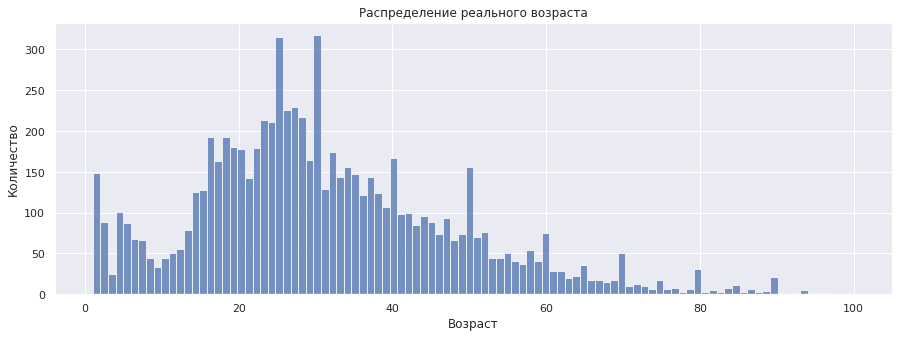

In [7]:
sns.set(rc={"figure.figsize":(15 , 5)})
sns.histplot(x = labels.real_age, bins=100);
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение реального возраста')
plt.show()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Информативная гистограмма. Молодец, что используешь 100 бинов (корзин).</div>

число фотографий неравномерно распределено по возрастам

In [8]:
features, target = next(datagen_flow)

Возраст: 1


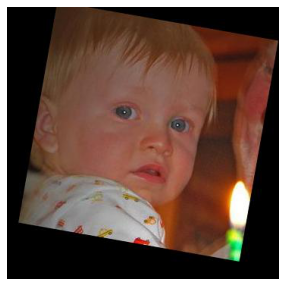

Возраст: 28


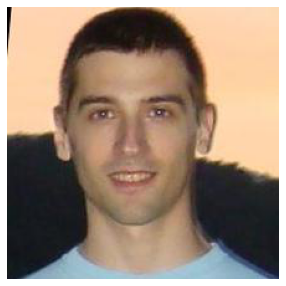

Возраст: 27


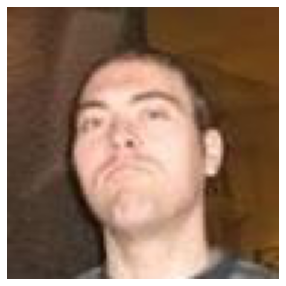

Возраст: 16


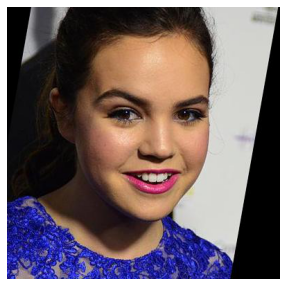

Возраст: 4


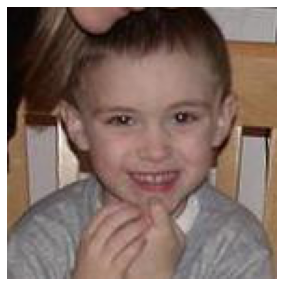

Возраст: 16


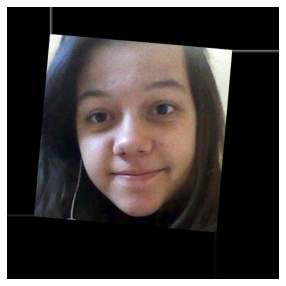

Возраст: 2


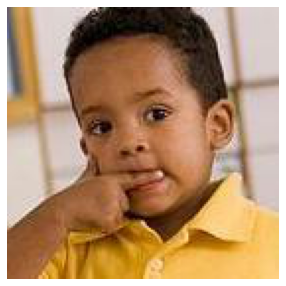

Возраст: 31


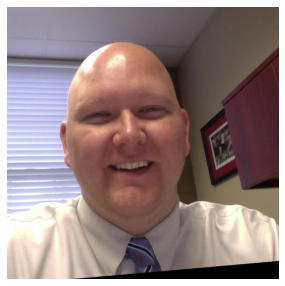

Возраст: 10


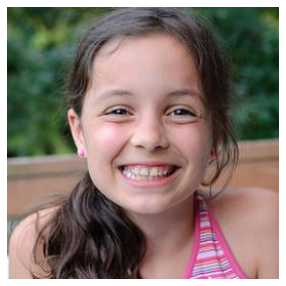

Возраст: 4


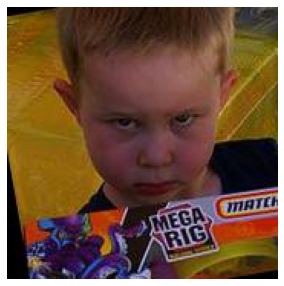

In [12]:
path = '/datasets/faces/final_files/'
for i in range(30, 40):
    print(f"Возраст: {labels.loc[i, 'real_age']}")
    image = Image.open(path+labels.loc[i, 'file_name'])
    plt.imshow(image)
    plt.axis('off')  # Убираем оси
    plt.grid(False)  # Убираем сетку
    plt.show()

На первый взгляд, фотографии выглядят адекватно заявленному возрасту людей на них.

#### Вывод
После изучения изображений, входящих в датасет, я сделал следующие наблюдения и выводы:

- **Распределение возрастов**: Фотографии людей распределены неравномерно по разным возрастам. Особенно мало фотографий детей в возрастах 3 и 9 лет, а также людей в старших возрастах от 60 лет. Это может привести к тому, что модель будет хуже обучаться определять возраст маленьких детей и стариков.

- **Качество изображений**: Визуально оценивая изображения, можно заметить, что некоторые из них имеют низкое качество или нечеткость. Это может повлиять на точность модели при обучении, поскольку низкое качество изображений может затруднить извлечение важных признаков и деталей.

- **Разнообразие лиц**: В датасете присутствуют различные типы лиц, включая разные расы, пол и физические особенности. Это может быть полезным для обучения модели на разнообразных данных и повышения ее обобщающей способности.

- **Наличие шума**: Некоторые изображения могут содержать шум, такой как фоновые объекты, размытие или артефакты. Это может быть вызвано различными факторами, такими как качество съемки или обработка изображений. Необходимо учитывать этот шум при обучении модели и принимать меры для его устранения или снижения влияния на результаты.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255.,
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            shuffle=False,
            seed=12345) 
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1/255.)    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            shuffle=False,
            seed=12345) 
    
    return val_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    # замораживаем ResNet50 без верхушки
    # Не замораживаем. Данных достаточно
    #backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

# age_mae печатает средний mae для предсказаний для каждого возраста
def age_mae(model, val_datagen_flow, validation_steps):

    #Извлекаем реальные значения лет для картинки
    val_datagen_flow.reset()
    real_ages = val_datagen_flow.labels
    #Получаем предсказание модели сколько лет человеку на картинке
    val_datagen_flow.reset()
    predictions = model.predict(val_datagen_flow, steps=validation_steps) 
    df = pd.DataFrame({'Real_Age': real_ages, 'Prediction': predictions.flatten(),'MAE': abs(real_ages-predictions.flatten())})

    # Группировка по real_ages и вычисление среднего отклонения
    grouped_df = df.groupby('Real_Age').agg({'Prediction': ['mean'], 'MAE': ['mean', 'count']})
    grouped_df.columns = ['Mean_Year_Prediction', 'Mean_MAE', 'Image_Count']
    pd.set_option('display.max_rows', None)
    print(grouped_df)


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    age_mae(model, test_data, validation_steps)
    return model

```

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Написаны функции для создания датагенераторов, а также создания и обучения модели. 
<hr>   
Молодец, что используешь агументацию для обучающего набора. 
<hr>   
    
Правильный выбор лосс-функции, также хорошо подобран шаг обучения.</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
задумка с функцией age_mae - 🔥 </div>

```
Train for 178 steps, validate for 60 steps
Epoch 1/40
2023-11-29 09:33:53.342065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-29 09:33:53.638090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 59s - loss: 220.5597 - mae: 10.8368 - val_loss: 706.3693 - val_mae: 21.7308
Epoch 2/40
178/178 - 37s - loss: 77.4400 - mae: 6.6800 - val_loss: 561.2717 - val_mae: 18.7142
Epoch 3/40
178/178 - 38s - loss: 50.2722 - mae: 5.5046 - val_loss: 293.8087 - val_mae: 12.5825
Epoch 4/40
178/178 - 38s - loss: 35.7301 - mae: 4.5520 - val_loss: 134.7128 - val_mae: 8.6036
Epoch 5/40
178/178 - 38s - loss: 27.4377 - mae: 4.0156 - val_loss: 96.0630 - val_mae: 7.7183
Epoch 6/40
178/178 - 38s - loss: 20.1990 - mae: 3.4162 - val_loss: 69.4945 - val_mae: 6.3098
Epoch 7/40
178/178 - 38s - loss: 14.8053 - mae: 2.9419 - val_loss: 90.7758 - val_mae: 7.1017
Epoch 8/40
178/178 - 38s - loss: 13.6155 - mae: 2.7503 - val_loss: 66.7294 - val_mae: 6.2545
Epoch 9/40
178/178 - 38s - loss: 12.1301 - mae: 2.5939 - val_loss: 64.5290 - val_mae: 5.9273
Epoch 10/40
178/178 - 38s - loss: 9.5493 - mae: 2.3223 - val_loss: 65.6686 - val_mae: 6.0514
Epoch 11/40
178/178 - 39s - loss: 9.3832 - mae: 2.2758 - val_loss: 65.5085 - val_mae: 6.0555
Epoch 12/40
178/178 - 48s - loss: 8.0867 - mae: 2.1295 - val_loss: 79.2261 - val_mae: 6.4934
Epoch 13/40
178/178 - 52s - loss: 8.3097 - mae: 2.1391 - val_loss: 63.2974 - val_mae: 5.9297
Epoch 14/40
178/178 - 51s - loss: 7.1018 - mae: 1.9954 - val_loss: 70.3827 - val_mae: 6.1360
Epoch 15/40
178/178 - 38s - loss: 6.5292 - mae: 1.9232 - val_loss: 63.8115 - val_mae: 5.9464
Epoch 16/40
178/178 - 38s - loss: 6.3610 - mae: 1.8859 - val_loss: 61.6779 - val_mae: 5.8702
Epoch 17/40
178/178 - 39s - loss: 6.2867 - mae: 1.8768 - val_loss: 72.4566 - val_mae: 6.5886
Epoch 18/40
178/178 - 50s - loss: 6.4129 - mae: 1.8961 - val_loss: 64.7258 - val_mae: 5.9524
Epoch 19/40
178/178 - 49s - loss: 6.3852 - mae: 1.9081 - val_loss: 61.4543 - val_mae: 5.8343
Epoch 20/40
178/178 - 48s - loss: 6.8122 - mae: 1.9571 - val_loss: 67.4620 - val_mae: 6.0452
Epoch 21/40
178/178 - 53s - loss: 7.2132 - mae: 2.0307 - val_loss: 62.9832 - val_mae: 5.8648
Epoch 22/40
178/178 - 68s - loss: 7.5400 - mae: 2.0525 - val_loss: 61.8387 - val_mae: 5.8197
Epoch 23/40
178/178 - 68s - loss: 7.1386 - mae: 2.0079 - val_loss: 59.2295 - val_mae: 5.7143
Epoch 24/40
178/178 - 62s - loss: 6.8537 - mae: 1.9840 - val_loss: 64.9548 - val_mae: 5.9026
Epoch 25/40
178/178 - 70s - loss: 6.8699 - mae: 1.9802 - val_loss: 69.2018 - val_mae: 6.3375
Epoch 26/40
178/178 - 44s - loss: 7.4875 - mae: 2.0778 - val_loss: 68.1057 - val_mae: 6.4059
Epoch 27/40
178/178 - 45s - loss: 6.6081 - mae: 1.9512 - val_loss: 61.6858 - val_mae: 5.7700
Epoch 28/40
178/178 - 51s - loss: 6.7224 - mae: 1.9266 - val_loss: 61.5373 - val_mae: 5.8682
Epoch 29/40
178/178 - 44s - loss: 6.0197 - mae: 1.8573 - val_loss: 60.5098 - val_mae: 5.7992
Epoch 30/40
178/178 - 45s - loss: 5.4395 - mae: 1.7519 - val_loss: 58.9594 - val_mae: 5.7202
Epoch 31/40
178/178 - 50s - loss: 5.4516 - mae: 1.7455 - val_loss: 66.1024 - val_mae: 6.1505
Epoch 32/40
178/178 - 41s - loss: 5.8957 - mae: 1.8191 - val_loss: 62.4115 - val_mae: 5.8261
Epoch 33/40
178/178 - 43s - loss: 5.8081 - mae: 1.8087 - val_loss: 60.1145 - val_mae: 5.7317
Epoch 34/40
178/178 - 49s - loss: 5.4849 - mae: 1.7566 - val_loss: 69.9995 - val_mae: 6.2481
Epoch 35/40
178/178 - 51s - loss: 6.4100 - mae: 1.9075 - val_loss: 66.0118 - val_mae: 6.1269
Epoch 36/40
178/178 - 51s - loss: 5.9111 - mae: 1.8301 - val_loss: 59.4809 - val_mae: 5.7461
Epoch 37/40
178/178 - 51s - loss: 10.2526 - mae: 2.3841 - val_loss: 64.6673 - val_mae: 6.0634
Epoch 38/40
178/178 - 51s - loss: 9.0515 - mae: 2.2753 - val_loss: 61.3462 - val_mae: 5.7243
Epoch 39/40
178/178 - 38s - loss: 6.0112 - mae: 1.8616 - val_loss: 59.0849 - val_mae: 5.6134
Epoch 40/40
178/178 - 38s - loss: 4.5730 - mae: 1.6164 - val_loss: 57.3159 - val_mae: 5.6017
          Mean_Year_Prediction   Mean_MAE  Image_Count
Real_Age                                              
1                     2.562454   2.020898           45
2                     5.198903   3.488662           24
3                     7.476393   4.636464            9
4                     8.303737   5.112123           30
5                    11.789045   6.968778           29
6                    11.112042   6.073140           20
7                    12.930903   6.406588           22
8                    10.389023   3.376724           13
9                    12.577782   6.353435           11
10                   15.933767   6.294984           12
11                   15.966769   5.320753           14
12                   16.764708   6.010504           13
13                   21.860928   9.064112           22
14                   20.228168   6.279088           36
15                   19.771996   4.879305           35
16                   19.403858   4.211470           44
17                   20.067514   3.730672           52
18                   23.180355   5.587453           50
19                   22.885944   4.707708           47
20                   21.999758   3.598892           45
21                   24.312408   4.830501           31
22                   23.427671   3.260030           47
23                   22.807589   3.731130           62
24                   26.221418   4.607845           55
25                   26.164841   3.740564           88
26                   26.970301   4.412998           60
27                   26.969790   3.787036           61
28                   28.218229   4.753544           51
29                   27.560776   4.264080           37
30                   28.485971   5.300437           88
31                   30.351620   4.582968           26
32                   28.859303   4.865241           34
33                   29.938198   4.658311           29
34                   32.390446   6.194759           38
35                   31.670399   5.639576           40
36                   31.313793   6.409809           27
37                   33.093052   5.993593           29
38                   33.768265   5.655017           23
39                   33.361580   7.017538           19
40                   36.875462   6.938383           51
41                   36.591187   6.505923           22
42                   34.656666   9.350153           22
43                   39.659801   5.510052           18
44                   39.326992   7.073046           26
45                   36.032719   9.553577           22
46                   41.043385   6.280656           11
47                   40.127033   8.396680           19
48                   45.999420   5.949349           18
49                   41.361454   8.914193           18
50                   43.822380   8.524343           46
51                   44.194046   7.333932           13
52                   44.291096   8.008061           15
53                   46.025276   8.021726            9
54                   45.970284   8.459251           12
55                   47.124157   7.875844            9
56                   47.179852   9.328943            6
57                   51.729553   6.083825           12
58                   48.604481   9.395520           10
59                   53.910133   6.608253           11
60                   57.279224   7.371245           26
61                   63.423897   9.042852            4
62                   55.056675   9.097708            3
63                   53.842525   9.260307            4
64                   56.771641  11.227196            3
65                   57.770458   9.442206            9
66                   58.793648   7.206352            2
67                   61.025627   5.974371            4
68                   59.475704  16.677906            2
69                   61.084404   7.915598            4
70                   62.135494   9.109858           12
71                   68.221130   2.778870            1
72                   63.087601   8.912401            2
73                   67.166626   5.833374            2
75                   69.343178   6.915667            7
80                   71.196533  10.488299            9
82                   62.408119  19.591881            1
83                   63.758965  19.241035            1
84                   70.252319  13.747681            2
85                   70.289551  14.710447            2
86                   63.454205  22.545795            1
87                   81.751129   5.248871            1
88                   82.391739   5.608261            1
90                   77.633636  12.366367            6
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 57.3159 - mae: 5.6017
Test MAE: 5.6017

```

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Модель обучена и преодолела планку требуемой точности. И очень классно показана на каких возрастах модель больше всег ошибается. </div>

## Анализ обученной модели

Обученная модель дает достаточно хороший результат на валидационной выборке. Среднее абсолютное отклонение 5.6 лет. Что позволит сегментировать покупателей по возрастным группам с точностью плюс минус шесть лет.

Были рассмотрены средние предсказания возраста в разбивке по реальным возрастам людей на фотографиях. Наиболее точное предсказание было достигнуто для детей в возрасте 1-го года. Так как после этого возраста изменения внешности особенно сильны. Хороших результатов так же удалось добиться в средних возрастах от 20 до 35 лет. С другой стороны в старших возрастах точность сильно падает. Что может быть связано как с небольшим количеством фотографий для обучения в данных возрастах. Так и с тем что люди в этом возрасте могут сильно отличаться и скажем в 60 лет выглядеть на 50 или на 70 лет.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы